## Network Science Course 
Our proposal was running three different algorithms to calculate Bits Per link.
1- Reverse CutHill Mckee
2- Fiedler Vector
3- LinearOrdering (Cameron Algorithm)


### Bit per link (BPL):
Following the paper, we will use a formulation from paper.

A network is described by a weighted directed graph $ G = (V, E)$, where $ V = \{1, 2, \ldots, n\} $ is the set of nodes (vertices) and $ E $ is the set of directed edges. If $ ij \in E $, then there exists an edge $ i \rightarrow j $. Denote by $ w_{ij} $ the nonnegative weight of the directed edge $ ij $ between nodes $ i $ and $ j $; if $ ij \notin E $, then $ w_{ij} = 0 $. Let $ \pi $ be a bijection

$ \pi : V \rightarrow \{1, 2, \ldots, n\}. $

The purpose of the link-weighted version of MLogA is to minimize

$\sum_{ij \in E} w_{ij} \left| \lg \left(\pi(i) - \pi(j)\right) \right| $

NOTE: Our Graph is not weighted and it in undirected graph.

> *For more details, please refer to https://arxiv.org/abs/1004.5186.*

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, isspmatrix
from scipy.linalg import det, inv, fiedler
import scipy
from scipy.sparse.csgraph import reverse_cuthill_mckee
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import math
from tqdm import tqdm
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
from scipy.sparse import csr_matrix, find
import time

In [1]:
# Function to calculate bits per link using the formula from the paper
def bits_per_link(matrix):
    # Calculate the bit cost for all edges
    bits = 0
    rows, cols = matrix.nonzero()
    for i in tqdm(range(len(rows))):
        # sounds bit per graph, not nits per link
        bits += math.log2(abs(rows[i] - cols[i]) + 1)  # +1 to handle log(0) case
    return bits/len(rows)

## Dataset
Our final goal is to run a graph from Agatha. We start with one of the experiments from Agatha "aapp-aapp" Edgelist. 
Please note that all Experiments have been run in Darwin. Also, the edge list for this experiment has been in .csr format. "Compressed Sparse Rows" format. 
It is worth mentioning that it is a 22M*22M Graph with almost 561M nonzero elements.

In [3]:
exp_csr = scipy.sparse.load_npz("/lustre/acslab/shared/Agatha_shared/2021_11_22/ensemble/adj_matrices_abstr_enrich/scipy_csr/aapp_aapp_edgelist.npz")

In [4]:
print("Shape of csr_matrix:", exp_csr.shape)
print("Number of stored elements:", exp_csr.nnz)

Shape of csr_matrix: (22054433, 22054433)
Number of stored elements: 561935538


## Sparsity of Matrix
Let $ A $ be a matrix with $n × m $ dimensions. The total number of elements in $ A $ is $ n × m $. Let $ Z $ be the zero elements in $ A $. The sparsity of matrix 
$ A $ , denoted as $ S(A) $ , is then calculated as the ratio of the number of zero elements to the total number of elements in the matrix:
$ S(A) $ = $ Z $ / $ n × m $.

We have  $ 1.155 × 10 ^{-6}$.


In [41]:
rows, cols = 22054433, 22054433
num_elements = 561935538
total_possible_elements = rows * cols

sparsity = num_elements / total_possible_elements
sparsity

1.1552998176936326e-06

In [11]:
exp_csr
exp_csr[3].nonzero()
exp_csr[3, 9518002]

True

In [19]:
sub_graph_1k= exp_csr[:1000,:1000]
sub_graph_10k= exp_csr[:10000,:10000]
sub_graph_100k= exp_csr[:100000,:100000]
sub_graph_1M= exp_csr[:1000000,:1000000]
sub_graph_5M= exp_csr[:5000000,:5000000]
sub_graph_10M= exp_csr[:10000000,:10000000]

In [12]:
sub_graph_1k

<1000x1000 sparse matrix of type '<class 'numpy.bool_'>'
	with 4 stored elements in Compressed Sparse Row format>

In [7]:
sub_graph_1k.nonzero()

(array([ 17, 207, 511, 836], dtype=int32),
 array([511, 836,  17, 207], dtype=int32))

## RCM: Reverse Cuthill Mckee
We use Scipy to implement it.

In [39]:
bits_per_link(exp_csr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561935538/561935538 [25:59<00:00, 360228.35it/s]


22.230773180434156

In [40]:
reverse_subgraph= reverse_cuthill_mckee(exp_csr)

In [22]:
%%time
rcm_matrix = exp_csr[reverse_subgraph, :][:, reverse_subgraph]

In [23]:
%%time
bits_per_link(rcm_matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1122262/1122262 [00:03<00:00, 364577.14it/s]


15.20794950227165

## Conclusion:
We computed our results with BPL metric; we observed that the difference between the original matrix before and after applying reverse Cuthill-McKee algorithm is about 30%.

Percentage Decrease = ((22.23 - 15.20) / 22.23) * 100% ≈ 31.62%

>* https://www.eecis.udel.edu/~isafro/papers/paper-rw.pdf.

## Visualization

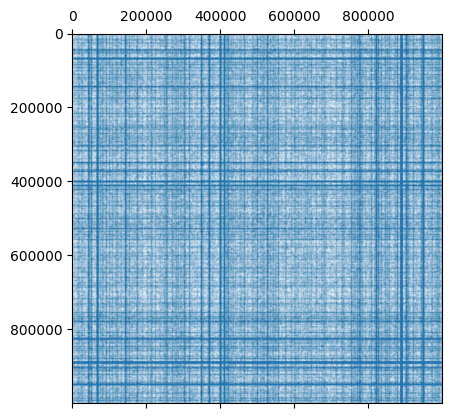

In [28]:
plt.spy(sub_graph_1M,markersize =0.01)

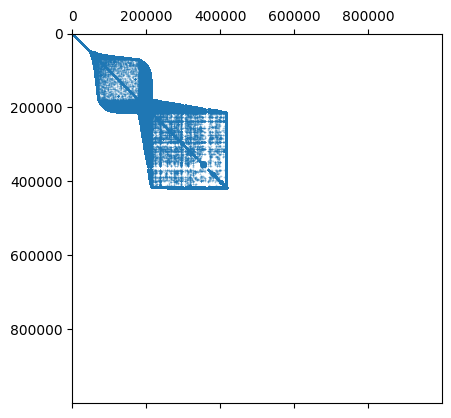

In [29]:
plt.spy(rcm_matrix,markersize=0.1)

## Fiedler Vector

It worth mentioning that We try with both Library Scipy [https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.fiedler.html] and Networkx [https://networkx.org/documentation/stable/reference/generated/networkx.linalg.algebraicconnectivity.fiedler_vector.html] to implement this, but the problem was scipy did not really implement Fiedler Vector It was Fiedler matrix. and Networkx is almost terrible at handling sparse matrix. so we stick to our own implementation.

In [31]:
sub_graph= exp_csr[:1000,:1000]

In [32]:
%%time
sub_graph = sub_graph.astype('float')
laplacian = sp.csgraph.laplacian(sub_graph, normed=False)

CPU times: user 15 µs, sys: 1.84 ms, total: 1.85 ms
Wall time: 2.82 ms


In [33]:
%%time 
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian, k=2, which='SM')

CPU times: user 69 ms, sys: 514 ms, total: 583 ms
Wall time: 127 ms


In [34]:
fiedler_vector = eigenvectors[:, 1]

In [35]:
node_order = np.argsort(fiedler_vector)

In [36]:
fv_matrix = sub_graph[node_order, :][:, node_order]

In [37]:
bits_per_link(fv_matrix)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 54120.05it/s]


1.0

## cubic complexity for calculating Eigenvalues :
There is an issue that the computational complexity of Fiedler Vector algorithms for finding eigenvalues is super-linear but sub-quadratic in the size of the matrix. For large sparse matrices, these methods are typically much faster than dense matrix eigenvalue algorithms, which have cubic complexity in the matrix size.

> *" MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000000000,) "*

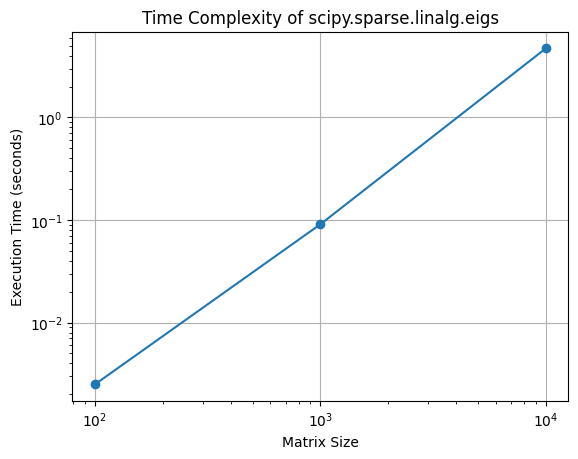

In [5]:
def create_sparse_matrix(size, density=0.01):
    return sp.rand(size, size, density=density, format='csr')

sizes = [100, 1000, 10000]
#  100000, 1000000

times = []

for size in sizes:
    matrix = create_sparse_matrix(size)
    start_time = time.time()
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(matrix, k=2)
    end_time = time.time()
    times.append(end_time - start_time)

# Plotting
plt.plot(sizes, times, marker='o')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Time Complexity of scipy.sparse.linalg.eigs')
plt.xscale('log')  
plt.yscale('log')
plt.grid(True)
plt.show()